In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
from IPython.display import display, clear_output
import time

In [2]:
df = pd.read_csv("tiny.csv", header=None)
df

,0,1
0,-1.085631,-0.678886
1,0.997345,-0.094709
2,0.282978,1.491390
3,-1.506295,-0.638902
4,-0.578600,-0.443982
5,1.651437,-0.434351
6,-2.426679,2.205930
7,-0.428913,2.186786
8,1.265936,1.004054
9,-0.866740,0.386186


In [3]:
cities = {i: (row[0], row[1]) for i, row in df.iterrows()}
num_cities = len(cities)

In [4]:
temp = 10000
cooling_rate = 0.001

In [5]:
def distance(city1, city2):
    return math.sqrt((city1[0] - city2[0]) ** 2 + (city1[1] - city2[1]) ** 2)

In [6]:
def total_distance(route):
    return sum(distance(cities[route[i]], cities[route[i - 1]]) for i in range(num_cities))

In [7]:
def initial_population(num_individuals, num_cities):
    population = []
    base_route = list(range(num_cities))
    for _ in range(num_individuals):
        random.shuffle(base_route)
        population.append(base_route[:])
    return population

In [8]:
def tournament_selection(population, tournament_size):
    competitors = random.sample(population, tournament_size)
    sorted_competitors = sorted(competitors, key=lambda x: total_distance(x))
    winner = sorted_competitors[0]
    return winner

In [9]:
def recombine(parent1, parent2):
    # Select two random crossover points
    crossover_points = sorted(random.sample(range(len(parent1)), 2))

    # Initialize the child route with the genetic material from parent1 in the crossover region
    child_route = parent1[crossover_points[0]:crossover_points[1]]

    # Map the cities that were swapped between parent1 and parent2
    mapping = {parent1[i]: parent2[i] for i in range(crossover_points[0], crossover_points[1])}

    # Iterate over the rest of the cities in parent2
    for city in parent2:
        if city not in child_route:
            # If the city is not in the crossover region, find its mapping and add it to the child
            while city in mapping:
                city = mapping[city]
            child_route.append(city)

    return child_route

In [10]:
def mutate(route):
    mutation_type = random.choice(['swap', 'insert'])

    if mutation_type == 'swap':
        # Swap mutation
        swap_index1, swap_index2 = random.sample(range(len(route)), 2)
        route[swap_index1], route[swap_index2] = route[swap_index2], route[swap_index1]
    else:
        # Insertion mutation
        index_to_remove = random.randint(0, len(route) - 1)
        city_to_insert = route.pop(index_to_remove)
        index_to_insert = random.randint(0, len(route))
        route.insert(index_to_insert, city_to_insert)

    return route

In [11]:
def survivor_selection(old_population, offspring, retain_length, random_select_rate=0.05):
    
    sorted_population = sorted(old_population + offspring, key=total_distance)
    new_population = sorted_population[:retain_length]

    for individual in sorted_population[retain_length:]:
        if random.random() < random_select_rate:
            new_population.append(individual)

    while len(new_population) > len(old_population):
        new_population.pop()

    return new_population

In [12]:
def plot_live_distance_changes(distances):
    plt.figure(figsize=(10, 5))
    plt.plot(distances, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Live Changes in Distance')
    plt.grid(True)
    plt.show()

In [13]:
def plot_live_route(route, title=""):
    x = [cities[i][0] for i in route] + [cities[route[0]][0]]
    y = [cities[i][1] for i in route] + [cities[route[0]][1]]
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, 'ro-')
    plt.plot(x[0], y[0], 'bo')
    plt.title(title + " Distance: " + str(total_distance(route)))
    plt.show()

In [14]:
route = list(cities.keys())
random.shuffle(route)
initial_route = route[:]

In [15]:
def simulated_annealing(route, temp, cooling_rate):
    current_route = route[:]
    best_route = route[:]
    current_population = initial_population(5, num_cities)
    best_distance = total_distance(route)
    distances = [best_distance]

    while temp > 1:
        new_population = []

        for _ in range(len(current_population)):
            parent1 = tournament_selection(current_population, 3)
            parent2 = tournament_selection(current_population, 3)

            if random.random() < 0.5:
                child = recombine(parent1, parent2)
            else:
                child = mutate(parent1)

            current_distance = total_distance(child)

            if current_distance < best_distance:
                best_distance = current_distance
                best_route = child
                plot_live_route(best_route, "Optimized Route via Simulated Annealing")
                time.sleep(0.001)
                clear_output(wait=True)

            new_population.append(child)

        current_population = survivor_selection(current_population, new_population, len(current_population))
        temp *= (1 - cooling_rate)

    return best_distance

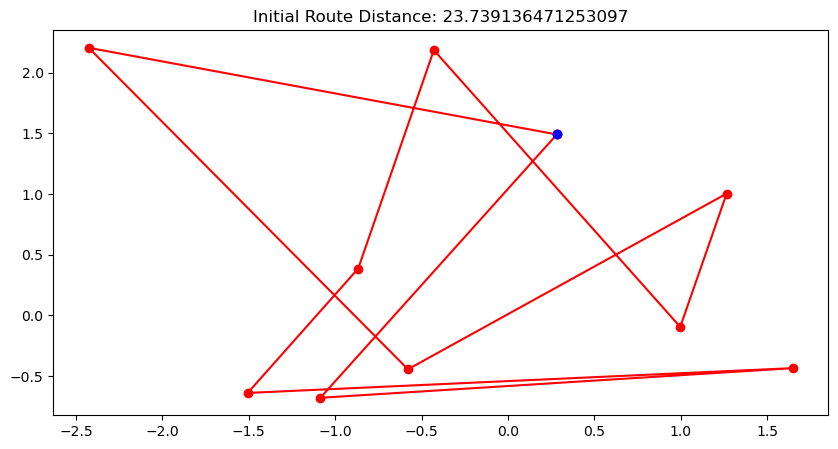

In [16]:
plot_live_route(initial_route, "Initial Route")

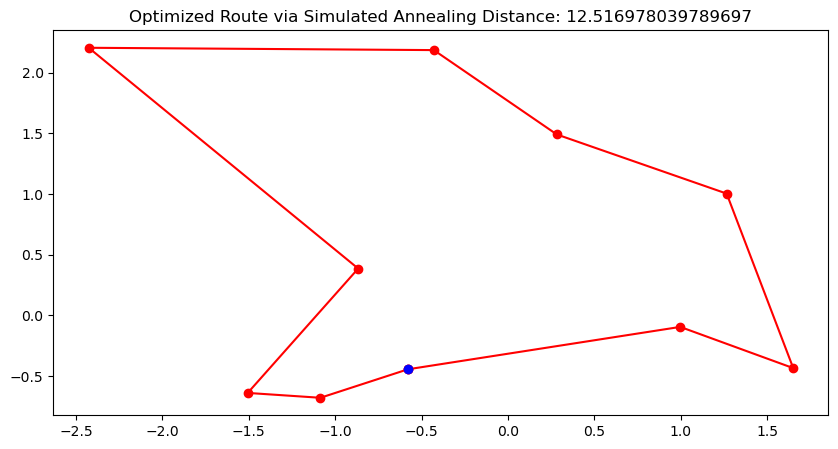

In [17]:
final_route = simulated_annealing(route, temp, cooling_rate)

In [21]:
final_route

12.516978039789697

In [18]:
def calculate_improvement(initial_distance, optimized_distance):
    improvement = ((initial_distance - optimized_distance) / (initial_distance)) * 100
    return improvement

In [20]:
improvement = calculate_improvement(total_distance(initial_route), final_route)
print(f"Improvement: {improvement:.2f}%")

Improvement: 47.27%
